In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Loading the datasets
customers = pd.read_csv('/content/drive/MyDrive/Zeotap_Internship/Customers.csv')
products = pd.read_csv('/content/drive/MyDrive/Zeotap_Internship/Products.csv')
transactions = pd.read_csv('/content/drive/MyDrive/Zeotap_Internship/Transactions.csv')

In [13]:
print("Customers Dataset Info:")
print(customers.info(), "\n")

print("Products Dataset Info:")
print(products.info(), "\n")

print("Transactions Dataset Info:")
print(transactions.info(), "\n")

Customers Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None 

Products Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None 

Transactions Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #  

In [14]:
# Converting date columns to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [15]:
# Merging datasets
data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

In [16]:
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


# **Task 3: Customer Segmentation / Clustering**

In [17]:
# Aggregating transaction data for each customer
customer_profiles = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'Quantity': 'sum',   # Total quantity purchased
    'Price_y': 'mean',     # Average product price
    'Category': lambda x: x.mode()[0],  # Most purchased category
    'Region': 'first',   # Customer region
}).reset_index()

customer_profiles.head()

,CustomerID,TotalValue,Quantity,Price_y,Category,Region
0,C0001,3354.52,12,278.334000,Electronics,South America
1,C0002,1862.74,10,208.920000,Clothing,Asia
2,C0003,2725.38,14,195.707500,Home Decor,South America
3,C0004,5354.88,23,240.636250,Books,South America
4,C0005,2034.24,7,291.603333,Electronics,Asia


In [18]:
# Preprocessing data

# Separating numerical and categorical features
numerical_features = ['TotalValue', 'Quantity', 'Price_y']
categorical_features = ['Category', 'Region']

# Creating Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)


In [19]:
# Transforming customer profiles
print(customer_profiles[numerical_features + categorical_features])
processed_data = preprocessor.fit_transform(customer_profiles[numerical_features + categorical_features])
print(processed_data)

     TotalValue  Quantity     Price_y     Category         Region
0       3354.52        12  278.334000  Electronics  South America
1       1862.74        10  208.920000     Clothing           Asia
2       2725.38        14  195.707500   Home Decor  South America
3       5354.88        23  240.636250        Books  South America
4       2034.24         7  291.603333  Electronics           Asia
..          ...       ...         ...          ...            ...
194     4982.88        12  416.992500   Home Decor         Europe
195     1928.65         9  227.056667  Electronics         Europe
196      931.83         3  239.705000     Clothing         Europe
197     1979.28         9  250.610000  Electronics         Europe
198     4758.60        16  296.506000     Clothing           Asia

[199 rows x 5 columns]
[[-0.06170143 -0.12203296  0.09467022 ...  0.          0.
   1.        ]
 [-0.87774353 -0.44800021 -0.90401592 ...  0.          0.
   0.        ]
 [-0.40585722  0.20393428 -1.09410928 

In [20]:
# Clustering using KMeans

# Choosing a number of clusters as 5
kmeans = KMeans(n_clusters=5, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(processed_data)
print(customer_profiles)

    CustomerID  TotalValue  Quantity     Price_y     Category         Region  \
0        C0001     3354.52        12  278.334000  Electronics  South America   
1        C0002     1862.74        10  208.920000     Clothing           Asia   
2        C0003     2725.38        14  195.707500   Home Decor  South America   
3        C0004     5354.88        23  240.636250        Books  South America   
4        C0005     2034.24         7  291.603333  Electronics           Asia   
..         ...         ...       ...         ...          ...            ...   
194      C0196     4982.88        12  416.992500   Home Decor         Europe   
195      C0197     1928.65         9  227.056667  Electronics         Europe   
196      C0198      931.83         3  239.705000     Clothing         Europe   
197      C0199     1979.28         9  250.610000  Electronics         Europe   
198      C0200     4758.60        16  296.506000     Clothing           Asia   

     Cluster  
0          1  
1        

In [21]:
# Calculating the Davies-Bouldin Index (DBI) to evaluate clustering
db_index = davies_bouldin_score(processed_data, customer_profiles['Cluster'])
print("Davies-Bouldin Index (DBI):", db_index)

Davies-Bouldin Index (DBI): 1.927647050566313


In [22]:
# Reduce dimensionality for visualization using PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(processed_data)
print(reduced_data)

[[-6.19572201e-02  1.67312967e-01]
 [-1.19748199e+00 -6.60670766e-01]
 [-4.63291042e-01 -1.13690081e+00]
 [ 1.73905779e+00 -1.06921682e+00]
 [-1.07069050e+00  7.06652986e-01]
 [ 5.21330052e-01  8.48599184e-01]
 [-5.14483487e-01  1.40714481e+00]
 [ 8.73916138e-01 -1.06783035e+00]
 [-1.96077787e+00  9.73145433e-01]
 [-1.29510564e+00 -1.52691192e+00]
 [ 2.72914503e-01  2.69628712e-01]
 [ 1.33816620e+00 -4.89031497e-01]
 [ 1.72791799e+00  2.32534139e-01]
 [-2.85664581e+00 -7.99873093e-01]
 [-1.44349836e+00  1.69839380e+00]
 [ 3.19304852e-01  1.69099765e+00]
 [ 1.18436465e+00 -1.10471821e+00]
 [ 1.01047312e+00 -5.63935171e-01]
 [-7.97863916e-01 -2.47369545e-01]
 [-1.86452588e+00  1.14707596e+00]
 [ 1.38335633e+00  2.43016707e-01]
 [ 6.95231947e-01 -7.57783357e-02]
 [ 1.29710062e+00  1.56258123e+00]
 [ 3.24018509e-01  2.76979784e-01]
 [-1.58597084e+00 -9.11053536e-01]
 [ 1.30743635e-01  6.59982319e-01]
 [-5.53034568e-01 -4.01396379e-01]
 [ 2.55234646e+00 -4.61263116e-01]
 [-1.24088726e+00 -7

In [23]:
# Adding PCA components and cluster labels to the dataframe
customer_profiles['PCA1'] = reduced_data[:, 0]
customer_profiles['PCA2'] = reduced_data[:, 1]
customer_profiles

,CustomerID,TotalValue,Quantity,Price_y,Category,Region,Cluster,PCA1,PCA2
0,C0001,3354.52,12,278.334000,Electronics,South America,1,-0.061957,0.167313
1,C0002,1862.74,10,208.920000,Clothing,Asia,2,-1.197482,-0.660671
2,C0003,2725.38,14,195.707500,Home Decor,South America,1,-0.463291,-1.136901
3,C0004,5354.88,23,240.636250,Books,South America,0,1.739058,-1.069217
4,C0005,2034.24,7,291.603333,Electronics,Asia,4,-1.070690,0.706653
...,...,...,...,...,...,...,...,...,...
194,C0196,4982.88,12,416.992500,Home Decor,Europe,3,1.055362,1.913404
195,C0197,1928.65,9,227.056667,Electronics,Europe,2,-1.189730,-0.277010
196,C0198,931.83,3,239.705000,Clothing,Europe,2,-2.190816,0.194541
197,C0199,1979.28,9,250.610000,Electronics,Europe,1,-1.073189,0.032631


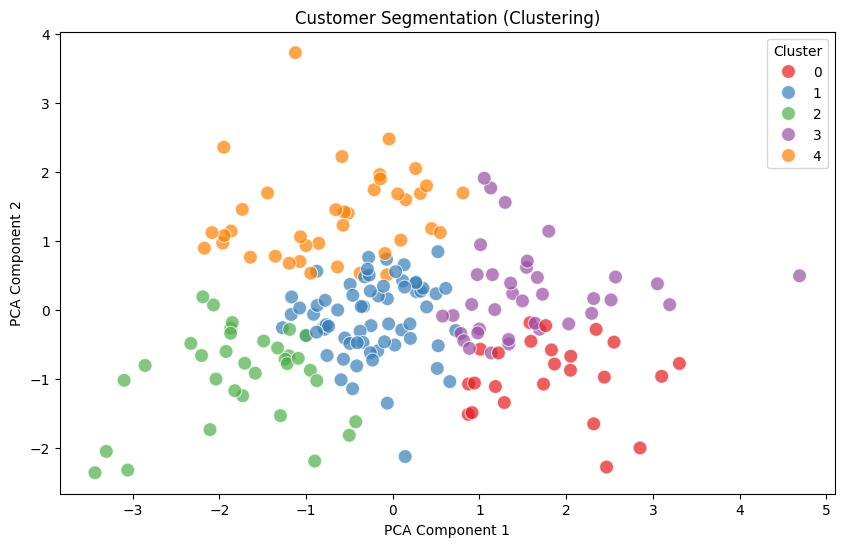

In [24]:
# Plotting clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_profiles, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=100, alpha=0.7)
plt.title('Customer Segmentation (Clustering)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [25]:
# Reporting the number of clusters, DB Index, and any other relevant metrics (e.g., cluster sizes)
cluster_sizes = customer_profiles['Cluster'].value_counts()
print("Cluster Sizes:\n", cluster_sizes)

Cluster Sizes:
 Cluster
1    67
4    39
3    36
2    33
0    24
Name: count, dtype: int64


In [26]:
# Exporting results
customer_profiles[['CustomerID', 'Cluster']].to_csv('customer_segments.csv', index=False)